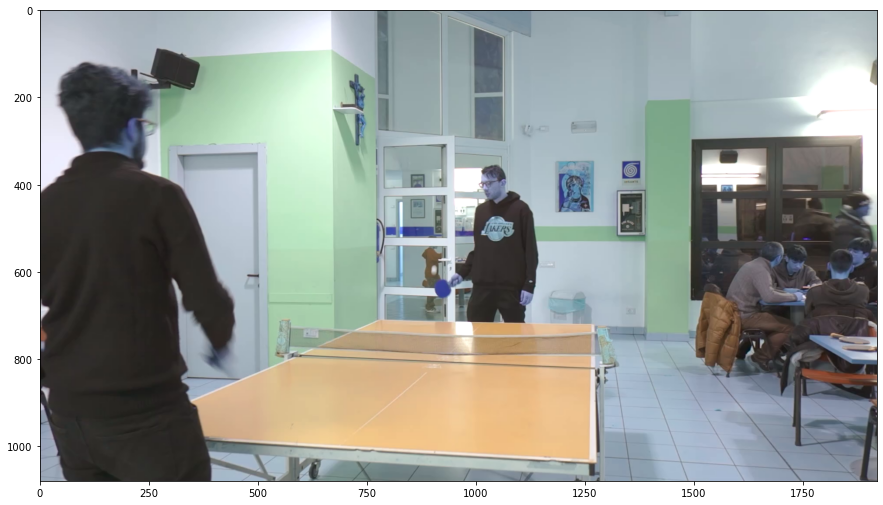

In [12]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import random

choosen_video = 'input_video.mp4'

cap=cv2.VideoCapture(choosen_video)

_,init_frame=cap.read()

plt.figure(figsize=(15,25))
plt.imshow(init_frame)

# I) Paddle tracking

## Tracking by HSV Color detection

Here we focus on the player just in front of the camera, seen from the back, as he is closer and thus more "appearant".
This player here uses the "red" face of the paddle, and we will use that info to extract the paddle pixels by only keeping those having the considered color. For a more convenient extraction, we will use the HSV image representation rather than the RGB initial one. 

Therefore we have to find the range of HSV values corresponding to the "red" (variating) paddle color, then we will filter the original image with a mask keeping only the right pixels, contained in this range of values.

### 1) Extracting the HSV representation of the paddle color (s)

 Find HSV colors bounds for further pixel selection

In [4]:
cap=cv2.VideoCapture(choosen_video)


# extract a pixel color on a given image by clicking on it
def mouseRGB(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN: 
        colorsB = image[y,x,0]
        colorsG = image[y,x,1]
        colorsR = image[y,x,2]
        colors = image[y,x]
        hsv_value= np.uint8([[[colorsB ,colorsG,colorsR ]]])
        hsv = cv2.cvtColor(hsv_value,cv2.COLOR_BGR2HSV)
        print ("HSV : " ,hsv)
        print("BRG Format: ",colors)
        print("Coordinates of pixel: X: ",x,"Y: ",y)
        print()
   

cv2.namedWindow('mouseRGB')
cv2.setMouseCallback('mouseRGB',mouseRGB)


# extract any number of useful HSV pixel values (should click on paddle several times, especially before it hits the ball)
while (1):
    
    # small delay to ease mouse selection
    time.sleep(0.3)
    
    image = cap.read()[1]
    image = cv2.resize(image, (1280,720))
    cv2.imshow("mouseRGB", image)
    
    # small delay to ease mouse selection
    time.sleep(0.3)
    
    # press esc when done
    if cv2.waitKey(20) & 0xFF == 27:
        break

        
cv2.destroyAllWindows()



HSV :  [[[  3 161 147]]]
BRG Format:  [ 54  62 147]
Coordinates of pixel: X:  404 Y:  590

HSV :  [[[  3 162 146]]]
BRG Format:  [ 53  61 146]
Coordinates of pixel: X:  410 Y:  596

HSV :  [[[  2 165 151]]]
BRG Format:  [ 53  61 151]
Coordinates of pixel: X:  419 Y:  609

HSV :  [[[  2 176 159]]]
BRG Format:  [ 49  55 159]
Coordinates of pixel: X:  432 Y:  612

HSV :  [[[  1 175 165]]]
BRG Format:  [ 52  56 165]
Coordinates of pixel: X:  435 Y:  616

HSV :  [[[  7 121 166]]]
BRG Format:  [ 87 105 166]
Coordinates of pixel: X:  491 Y:  426

HSV :  [[[ 12  98 154]]]
BRG Format:  [ 95 118 154]
Coordinates of pixel: X:  484 Y:  406

HSV :  [[[  2 163 160]]]
BRG Format:  [ 58  64 160]
Coordinates of pixel: X:  481 Y:  396



In [13]:
# Bounds definition (cf openCV guide on object detection with HSV color detection)

lower=np.array([0,100,100])
upper=np.array([7,255,255])

### 2) Filtering the image to extract paddle contours

Selecting useful pixels according to the range of colors previousfly found. This should keep only the paddle pixels.

In [14]:
cap=cv2.VideoCapture(choosen_video)

# image on which we will plot the sequence of pts of the racket traj
_, draw_trajectory=cap.read()
limit_frame=100

fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
out = cv2.VideoWriter('results/tracking_videos/racket_tracking.mp4', fourcc, 25.0, (1920, 1080))


# extracting shape on the first frame of the video
ret, frame = cap.read()
h, w, _ = frame.shape

frame_nb=0

while cap.isOpened():
    
    frame_nb=frame_nb+1
    
    # reading the next frame
    success, img = cap.read()
    
    if not isinstance(img,np.ndarray):
        break
        
    # converting the frame from RGB to HSV    
    hsv_img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    
    # selecting pixels
    mask=cv2.inRange(hsv_img, lower,upper);
    
    # showing mask corresponding video
    cv2.imshow("mask",mask)
    
    # extracting useful contours (should be the paddle ones)
    contours,_ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # drawing the contours on original video
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        center=[ int(x+(w/2)) , int(y+(h/2)) ]
        if cv2.contourArea(contour) <2000:
            continue
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 10)
        cv2.circle(img,center,7,(0,0,255),-1)
        if frame_nb<limit_frame:
            cv2.circle(draw_trajectory,center,7,(0,0,255),-1)
        cv2.putText(img, "Status: {}".format('preparing shoot'), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 0, 255), 3)
    
    # show original video with extracted paddle contours
#     img = cv2.resize(img, (1920, 1080))
    cv2.imshow("orig",img)
    
    # save a video with extracted contours
    out.write(img)

    # press q to exit at everytime
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
        
        
# cv2.imwrite('racket_traj.jpg',draw_trajectory)
        
out.release()
cap.release()
cv2.destroyAllWindows()

# II) Ball tracking

We must adopt a different method here. Indeed, we wish we could follow the same way and filter the pixels by HSV vector, keeping only the ball pixels, but the ball is small, moves fast and is subject to important color changes on the video due to variable exposition/luminosity.

Therefore we will apply a different method which rely on the fact that the ball is a (fast) moving object : background substraction. It consists in computing the "mean frame" of the video taking into account the N last frames period, where N is a tunable parameter (see below). Thus it computes a "mean pixel" over the N last frames for each coordinate, with a given specific method (Gaussian Mixture, Median Blur...). Then the calculated "mean frame" is substracted to the current frame pixel-wise. If the absdiff between the current pixel and the mean pixel at (x,y) is greater than a certain threshold T (tunable parameter), (x,y) is considered as a "foreground pixel" that is part of a moving entity. Then each pixel on the image is categorized either as a foreground (diff>T) or a background pixel (diff<T), and the "moving entities" on the current frame can be extracted.

This done, we are left with a bw image on which the moving "foreground" elements are in white and the "background" is in black. This image is still quite noisy, so we use morphological operators to perform "erosion" and "dilatation" in order to remove small amounts of white noisy/irrelevant pixels. 
More precisely, we apply a closing step (dilatation -> erosion) followed by an opening step (erosion -> dilatation. This whole process is supposed to efficiently denoise the image and (almost) retain the only useful elliptic convex blob ( = amount of connex white pixels) : the ball!

Finally, we use the openCV blob detector with custom tunable parameters on this denoised bw image to capture the ball area.

In [25]:
# Defining a part of interest in the video and extracting the image on which we will plot the sequence of points of the 
# ball traj
cap = cv2.VideoCapture(choosen_video)


limit_frame_low=390
limit_frame_up=420
nb=1
# here two "well-delimited" frame sequences (e.g parts of the video involving a single shot and where
# the tracking performs good) : 190-210 , 390-420

frame_nb=0

while frame_nb<limit_frame_low:
    frame_nb=frame_nb+1
    _, draw_trajectory=cap.read()
    
    k = cv2.waitKey(30)
    if k == ord('q'):
        break
    
    
cap.release()
cv2.destroyAllWindows()

In [26]:
# Begin tracking
cap = cv2.VideoCapture(choosen_video)


fps = cap.get(cv2.CAP_PROP_FPS)

# trajectory parameters
t_init=0
# 1 frame represent (1/fps) second IRL then we can calculate the corresponding timestamp t at each step with:
time_step=(1/fps)
timestamp=t_init
timestamps=[]
ball_frame_positions=[]


fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
out = cv2.VideoWriter('results/tracking_videos/ball_tracking.mp4', fourcc, 25.0, (1920, 1080))

# _, frame=cap.read()
# h, w, _ = frame.shape


fgbg = cv2.createBackgroundSubtractorMOG2(
    history=15, varThreshold=50, detectShadows=False
)


# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 50
# params.maxThreshold = 100
# Filter by Color (it will be used on bw image)
params.filterByColor = True
params.blobColor = 255
# Filter by Area (remove too small and too big amount of pts)
params.filterByArea = True
params.minArea = 200
params.maxArea = 1000
# Filter by Circularity (the ball should look ~ circular)
params.filterByCircularity = True
params.minCircularity = 0.6
# Filter by Convexity (the ball should be a convex shape)
params.filterByConvexity = True
params.minConvexity = 0.5
# Filter by Inertia (degree of resemblance to a circle?)
params.filterByInertia = True
params.minInertiaRatio = 0.08

# Create a blob detector with the previous parameters
detector = cv2.SimpleBlobDetector_create(params)

frame_nb=0

while True:
    
    frame_nb=frame_nb+1
    
    # updating the time variable, taking into account the framerate of the video
    timestamp=timestamp+time_step
    
    
    ret, frame = cap.read()
    
    if frame is None:
        break  
    
    # background substraction to retain only foreground (=moving) elements, including the ball
    fg_filt=fgbg.apply(frame)
    cv2.imshow('background filtered', fg_filt)
    

    # denoising and retain only the most relevant pixel blobs with closing-opening process
    
    se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    # structuring element (mask used for filtering) which will served during the erosion step of the closing phase
    se2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # structuring element (mask used for filtering) which will served during the erosion step of the opening phase
    fg_filt = cv2.morphologyEx(fg_filt, cv2.MORPH_CLOSE, se1)
    # first we perform closing on foreground filtered bw image  
    fg_filt = cv2.morphologyEx(fg_filt, cv2.MORPH_OPEN, se2)
    # then finally opening
    cv2.imshow('after_closing_opening', fg_filt)
    

    # blob detection on preprocessed and denoised image, should capture ball pixels
    keypoints = detector.detect(fg_filt)  
    
    
    # Show current frame nb and timestamp
    cv2.putText(frame, "Frame number: {}".format(str(frame_nb)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 0, 255), 3)
    cv2.putText(frame, "Time: {}".format(str(round(timestamp,2))), (1750, 20), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 0, 255), 3)
    
    # Show keypoints    
    if (len(keypoints)>0): 
        frame = cv2.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        for i in range(len(keypoints)):
#             cv2.circle(frame, [int(keypoints[i].pt[0]), int(keypoints[i].pt[1])], 5,(0, 255, 255), -1) 
            if (frame_nb<limit_frame_up and frame_nb>limit_frame_low):
                timestamps.append(timestamp)
                ball_x=int(keypoints[i].pt[0])
                ball_y=int(keypoints[i].pt[1])
                ball_position=[ball_x,ball_y]
                ball_frame_positions.append(ball_position)
                cv2.circle(draw_trajectory, ball_position, 7,(255, 255, 255), -1)    

    
    cv2.imshow("Keypoints", frame)
    out.write(frame)

    

    k = cv2.waitKey(30)
    if k == ord('q'):
        break
        
cv2.imwrite('results/extracted_seq/seq'+str(nb)+'.jpg',draw_trajectory)
out.release()
cap.release()
cv2.destroyAllWindows()

In [27]:
len(ball_frame_positions), len(timestamps)

(9, 9)

In [28]:
# USEFUL RESULTS TO EXPORT

In [29]:

%store ball_frame_positions
%store timestamps

Stored 'ball_frame_positions' (list)
Stored 'timestamps' (list)
